# Scraping Notícias

In [ ]:
# Importar bibliotecas
import requests
import re
import pandas as pd
from bs4 import BeautifulSoup

In [ ]:
# Carregar base com as urls
urls = pd.read_excel('/content/urls.xlsx', sheet_name ='G1(RMGV)')

In [ ]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}

linkMateria = []
tituloMateria = []
corpoMateria = [] 

for url in urls.url: 
  try:
    req = requests.get(url)
    soup = BeautifulSoup(requests.get(url, headers=headers).content, "html.parser")

    link = url
    if soup.find('h1',itemprop="headline"):
        titulo = soup.find('h1',itemprop="headline")
        
    else:
        titulo = soup.find('h1',class_="entry-title")
    
    tituloMateria.append(titulo.text)
    linkMateria.append(link)

    if soup.find('div', attrs={'class':'mc-article-body'}):
      d = soup.find('div',class_='mc-article-body')
      p = d.find_all('p', class_="content-text__container")
      corpoMateria.append(p)

    else:      
      d = soup.find('div',class_='materia-conteudo entry-content clearfix')
      p = d.find_all('p')
      corpoMateria.append(p)
  
  except:
    pass

In [ ]:
# Converter para df
df = pd.DataFrame(list(zip(linkMateria,tituloMateria, corpoMateria)), columns=['link','titulo','materia'])
df.head(3)

,link,titulo,materia
0,https://g1.globo.com/es/espirito-santo/noticia...,Homem é preso após ser perseguido por guardas ...,[[ Um homem que dirigia um carro roubado foi p...
1,https://g1.globo.com/es/espirito-santo/noticia...,Homem é agredido e preso depois de assaltar ba...,[[ Um homem de 38 anos foi agredido depois de ...
2,https://g1.globo.com/es/espirito-santo/noticia...,"Suspeitos de assaltos em Vila Velha, ES, são a...",[[ Três homens suspeitos de assaltos em Vila V...


In [ ]:
df.to_excel('g1RMGV.xlsx')

# Mineração de Texto

In [2]:
# Importar bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import re
import pandas as pd

In [3]:
# Baixar módulos
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# Ler base
df = pd.read_excel('/content/g1RMGV.xlsx')

# Remover duplicados
df = df.drop_duplicates(subset=['link'], keep='first')

In [5]:
# Lista de stopwords customizada
stopWords = []

stopwords_pretext = open('/content/rmgvStopwords.txt', 'r')

with stopwords_pretext as f:
    stopwords_pretext = f.read().splitlines()

stopWords = stopwords_pretext

In [6]:
# Unir lista customizada com as palavras da NLTK
stopNLTK = stopwords.words('portuguese')
stopWords += stopNLTK

# Funções

In [7]:
# Função para remover elementos de html
def parser(text):
    return re.sub('<[^<]+?>', '', str(text))

# Função para limpar os textos do título e do subtítulo
def limparTitulos(df):
  replacer = {'\n':' ',"[\[].*?[\]]": "",'[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’""′‘\\\]':" ", ' +': ' '}
  df = df.replace(replacer, regex=True).apply(lambda x: x.strip()).apply(lambda x: " ".join(x.lower() for x in x.split()))
  df = df.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8', errors='ignore')
  df = df.apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))
  return df

# Função para limpar o texto das matérias
def limparMateria(df):
  replacer = {'\n':' ','[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’""′‘\\\]':" ", ' +': ' '}
  df = df.replace(replacer, regex=True).apply(lambda x: x.strip()).apply(lambda x: " ".join(x.lower() for x in x.split()))
  df = df.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8', errors='ignore')
  df = df.apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))
  return df

# Função para tokenizar os textos
def tokenizar(df):
  df = df.apply(word_tokenize,language='portuguese') 
  return df  

# Função para contar o número de palavras por texto
def contarPalavras(df):
  lists =  df

  words = []
  for wordList in lists:
    words += wordList
  FreqDist(words)

  # Elencar os x termos mais frequentes
  fdist = FreqDist(words)
  
  # Transforma em df
  termos = pd.DataFrame(list(fdist.items()), columns = ["Termos", "Frequência"]).sort_values(by=['Frequência'], ascending=False)
  
  return termos

# Função para gerar as nuvens de palavras
def gerarNuvem(df):
  df = df.set_index('Termos').to_dict()['Frequência']
  wc = WordCloud(mode = "RGBA", background_color=None,width=800, height=400, max_words=50).generate_from_frequencies(df)

  plt.figure(figsize=(10, 10))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.show()
  return plt.show()

# Pré-processamento

In [8]:
df['materiaLimpa'] = df.materia.apply(parser)
df['tituloLimpo'] = limparTitulos(df['titulo'])
df['cleanmateriaLimpa'] = limparMateria(df['materiaLimpa'])

In [9]:
df['tokenizeTitulo'] = tokenizar(df['tituloLimpo'])
df['tokenizeMateria'] = tokenizar(df['cleanmateriaLimpa'])

# Tokenização e frequências

In [11]:
frequenciaTitulo = contarPalavras(df['tokenizeTitulo'])
frequenciaTitulo.head(50)

,Termos,Frequência
4,agredido,18
17,espancado,17
12,suspeito,16
13,assalto,10
0,homem,9
1,preso,7
6,assaltar,7
36,tentar,6
10,sao,5
34,mulher,5


In [12]:
frequenciaMateria = contarPalavras(df['tokenizeMateria'])
frequenciaMateria.head(50)

,Termos,Frequência
18,policia,121
27,suspeito,78
0,homem,59
53,bairro,52
123,vitima,49
70,pessoas,46
12,agredido,41
149,local,40
147,moradores,40
77,levado,40


# Nuvem de palavras

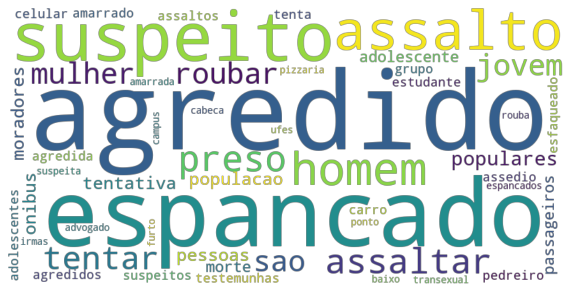

In [ ]:
gerarNuvem(frequenciaTitulo)

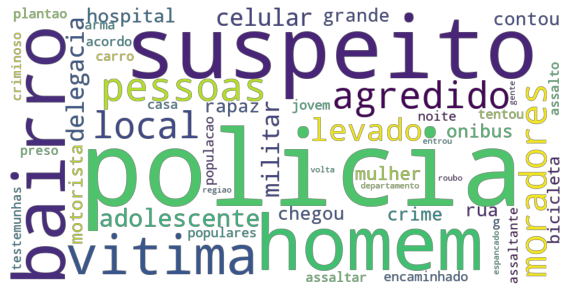

In [ ]:
gerarNuvem(frequenciaMateria)